In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

PREPROCESSED_ROOT = PROJECT_ROOT / "preprocessed_dataset"

print("PREPROCESSED_ROOT:", PREPROCESSED_ROOT)
print("PROJECT_ROOT:", PROJECT_ROOT)

PREPROCESSED_ROOT: E:\DL_audiotomidi\preprocessed_dataset
PROJECT_ROOT: E:\DL_audiotomidi


In [2]:
import math
import random
import numpy as np

import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F

from models.crnn_2_amt import CRNNCompactFO
from scripts.dataset_helpers import create_dataloaders
from scripts.evaluate import evaluate_crnn, frame_level_f1, build_onset_targets_from_frames

import wandb

import time

In [3]:
# SPEC_TYPE="mel" for Mel-Spectrogram
SPEC_TYPE = "cqt"
# N_FREQ_BINS=229 for Mel-Spectrogram
N_FREQ_BINS = 252
N_PITCHES = 88

BATCH_SIZE = 16
CHUNK_LEN = 512
NUM_WORKERS = 4

NUM_EPOCHS = 200

BASE_LR = 3e-4
WEIGHT_DECAY = 1e-4
# WARMUP for Learning Rate
WARMUP_RATIO = 0.1

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HOP_LENGTH = 512
SR = 22050
# Binarization threshold
THRESHOLD = 0.5

# loss function weights
ONSET_LOSS_WEIGHT = 1.0
FRAME_LOSS_WEIGHT = 1.0

# near-onset frame weight
FRAME_ONSET_ALPHA = 3.0

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

In [5]:
train_loader, val_loader = create_dataloaders(
    root_dir=str(PREPROCESSED_ROOT),
    spec_type=SPEC_TYPE,
    batch_size=BATCH_SIZE,
    chunk_len=CHUNK_LEN,
    num_workers=NUM_WORKERS,
)

print("train batches:", len(train_loader))
print("val batches:", len(val_loader))

train batches: 61
val batches: 9


In [6]:
num_training_steps = NUM_EPOCHS * len(train_loader)
print("training steps:", num_training_steps)
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)
print("warmup steps:",num_warmup_steps)

training steps: 12200
warmup steps: 1220


In [7]:
def lr_lambda(current_step: int):
    # warmup
    if current_step < num_warmup_steps:
        return float(current_step) / max(1, num_warmup_steps)

    # cosine decay
    progress = float(current_step - num_warmup_steps) / max(
        1, num_training_steps - num_warmup_steps
    )
    return 0.5 * (1.0 + math.cos(math.pi * progress))

In [8]:
model = CRNNCompactFO(
    n_freq_bins=N_FREQ_BINS,
    n_pitches=N_PITCHES,
    cnn_channels=(32, 64, 96, 128),
    onset_hidden=128,
    frame_hidden=160,
    onset_blocks=1,
    frame_blocks=2,
    rnn_dropout=0.2
)
model.to(DEVICE)

optimizer = AdamW(
    model.parameters(),
    lr=BASE_LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

model

CRNNCompactFO(
  (stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn2d): Sequential(
    (0): PreActResBlock2D(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (skip): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 1), bias=False)
    )
    (1): PreActResBlock2D(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [9]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable:,}")

Trainable parameters: 1,672,016


In [10]:
# giving less weights to zeros 
onset_pos_weight_value = 7
frame_pos_weight_value = 4

onset_pos_weight = torch.full((N_PITCHES,), onset_pos_weight_value, device=DEVICE)
frame_pos_weight = torch.full((N_PITCHES,), frame_pos_weight_value, device=DEVICE)

# separate criterions for separate heads
onset_criterion = nn.BCEWithLogitsLoss(
    pos_weight=onset_pos_weight
)

frame_criterion = nn.BCEWithLogitsLoss(
    pos_weight=frame_pos_weight
)

In [11]:
def train_one_epoch(
    model: nn.Module,
    dataloader,
    onset_criterion,
    frame_criterion,
    optimizer,
    scheduler,
    device: torch.device,
    epoch: int,
    log_interval: int = 50
):
    
    model.train()
    running_total_loss = 0.0
    running_onset_loss = 0.0
    running_frame_loss = 0.0
    running_f1 = 0.0
    num_batches = 0

    for batch_idx, (spec, target) in enumerate(dataloader):
        
        spec = spec.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        onset_logits, frame_logits = model(spec)
        B, T, P = frame_logits.shape


        onset_targets = build_onset_targets_from_frames(target)

        loss_onset = onset_criterion(
            onset_logits.reshape(B * T, P),
            onset_targets.reshape(B * T, P)
        )

        
        # frame loss with more weights near onsets
        w = torch.ones_like(target)
        w = w + FRAME_ONSET_ALPHA * onset_targets

        frame_logits_flat = frame_logits.reshape(B * T, P)
        frame_targets_flat = target.reshape(B * T, P)
        w_flat = w.reshape(B * T, P)

        # frame by frame loss
        frame_loss_raw = F.binary_cross_entropy_with_logits(
            frame_logits_flat,
            frame_targets_flat,
            reduction='none',
            pos_weight=frame_pos_weight
        )

 
        loss_frame = (frame_loss_raw * w_flat).sum() / w_flat.sum()

        # resulting loss
        loss = ONSET_LOSS_WEIGHT * loss_onset + FRAME_LOSS_WEIGHT * loss_frame

        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        batch_f1 = frame_level_f1(frame_logits.detach(), target.detach(), threshold=THRESHOLD)

        running_total_loss += loss.item()
        running_onset_loss += loss_onset.item()
        running_frame_loss += loss_frame.item()
        running_f1 += batch_f1
        num_batches += 1


    epoch_total_loss = running_total_loss / max(1, num_batches)
    epoch_onset_loss = running_onset_loss / max(1, num_batches)
    epoch_frame_loss = running_frame_loss / max(1, num_batches)
    epoch_f1 = running_f1 / max(1, num_batches)

    return epoch_total_loss, epoch_onset_loss, epoch_frame_loss, epoch_f1


In [12]:
def train(model,
          train_dataloader,
          val_dataloader,
          onset_criterion,
          frame_criterion,
          optimizer,
          scheduler,
          device,
          n_epochs,
          run=None,
          checkpoint_path=None,
          threshold=0.5,
          hop_length=512,
          sr=22050,
          log_interval=50,
):

    global_step = 0
    best_val_frame_f1 = 0.0

    total_start = time.time()
    
    for epoch in range(1, n_epochs + 1):

        epoch_start = time.time()
        
        # training phase
        train_total_loss, train_onset_loss, train_frame_loss, train_frame_f1 = train_one_epoch(
            model=model,
            dataloader=train_dataloader,
            onset_criterion=onset_criterion,
            frame_criterion=frame_criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            epoch=epoch,
            log_interval=log_interval
        )
        
        train_time_sec = time.time() - epoch_start
        
        global_step = epoch * len(train_dataloader)

        # validation phase
        val_start = time.time()
        val_total_loss, val_frame_f1, val_onset_loss, val_frame_loss, _ = evaluate_crnn(
            model=model,
            dataloader=val_dataloader,
            onset_criterion=onset_criterion,
            frame_criterion=frame_criterion,
            device=device,
            threshold=threshold,
            hop_length=hop_length,
            sr=sr,
            onset_tolerance=0.05,
            compute_note_f1=False,
            onset_loss_weight=ONSET_LOSS_WEIGHT,
            frame_loss_weight=FRAME_LOSS_WEIGHT,
        )

        val_time = time.time() - val_start
        epoch_time = time.time() - epoch_start

        print(
            f"[Epoch {epoch}/{n_epochs}] "
            f"train_loss={train_total_loss:.4f}, train_F1={train_frame_f1:.4f} | "
            f"val_loss={val_total_loss:.4f}, val_F1={val_frame_f1:.4f} | "
            f"epoch_time={epoch_time/60:.2f} min"
        )
        current_lr = optimizer.param_groups[0]["lr"]

        #wandb logging
        if run is not None:
            run.log(
                {
                    "epoch": epoch,
                    "train/loss": train_total_loss,
                    "train/loss_onset": train_onset_loss,
                    "train/loss_frame": train_frame_loss,
                    "train/frame_F1": train_frame_f1,
                    "val/loss": val_total_loss,
                    "val/loss_onset": val_onset_loss,
                    "val/loss_frame": val_frame_loss,
                    "val/frame_F1": val_frame_f1,
                    "lr": current_lr,
                    "time/train_epoch_sec": epoch_time,
                },
                step=global_step
            )

        #saving the best checkpoint by val_frame metric
        if checkpoint_path is not None and val_frame_f1 > best_val_frame_f1:
            best_val_frame_f1 = val_frame_f1
            torch.save(
                {
                    "model_state_dict": model.state_dict()
                },
                checkpoint_path
            )
            print(f"*** New best frame-F1={best_val_frame_f1:.4f}, saved to {checkpoint_path} ***")

    total_time = time.time() - total_start
    print(f"\n=== TOTAL TRAINING TIME: {total_time/3600:.2f} hours ===")

    if run is not None:
        run.log({"time/total_hours": total_time / 3600.0}, step=global_step)

    return best_val_frame_f1

In [13]:
CHECKPOINT_DIR = PROJECT_ROOT / "checkpoints"
print(CHECKPOINT_DIR)

best_ckpt_path = CHECKPOINT_DIR / f"crnnOF_{SPEC_TYPE}_best_cqt_changed_config_changedloss.pt"

E:\DL_audiotomidi\checkpoints


In [14]:
wandb_config = {
    "model": "CRNNCompactFO",
    "spec_type": SPEC_TYPE,
    "n_freq_bins": N_FREQ_BINS,
    "n_pitches": N_PITCHES,
    "batch_size": BATCH_SIZE,
    "chunk_len": CHUNK_LEN,
    "num_workers": NUM_WORKERS,
    "num_epochs": NUM_EPOCHS,
    "base_lr": BASE_LR,
    "weight_decay": WEIGHT_DECAY,
    "warmup_ratio": WARMUP_RATIO,
    "seed": SEED,
    "hop_length": HOP_LENGTH,
    "sr": SR,
    "threshold": THRESHOLD,
}

In [14]:
with wandb.init(
    project="DL_audiotomidi",
    name="CRNNCompactFO_cqt_changed_config_changedloss",
    config=wandb_config
) as run:

    best_val_frame_f1 = train(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        onset_criterion=onset_criterion,
        frame_criterion=frame_criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=DEVICE,
        n_epochs=NUM_EPOCHS,
        run=run,
        checkpoint_path=best_ckpt_path,
        threshold=THRESHOLD,
        hop_length=HOP_LENGTH,
        sr=SR,
        log_interval=50
    )

print("Best validation frame-F1:", best_val_frame_f1)

wandb: Currently logged in as: armaga (armaga-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



=== Epoch 1/200 ===
[Epoch 1/200] train_loss=1.5522, train_F1=0.0854 | val_loss=1.3247, val_F1=0.0679 | epoch_time=1.14 min
*** New best frame-F1=0.0679, saved to E:\DL_audiotomidi\checkpoints\crnnOF_cqt_best_cqt_changed_config_changedloss.pt ***

=== Epoch 2/200 ===
[Epoch 2/200] train_loss=1.2009, train_F1=0.0885 | val_loss=0.8871, val_F1=0.0230 | epoch_time=1.00 min

=== Epoch 3/200 ===
[Epoch 3/200] train_loss=0.8721, train_F1=0.0434 | val_loss=0.6398, val_F1=0.0080 | epoch_time=1.07 min

=== Epoch 4/200 ===
[Epoch 4/200] train_loss=0.7168, train_F1=0.0579 | val_loss=0.5290, val_F1=0.0742 | epoch_time=1.01 min
*** New best frame-F1=0.0742, saved to E:\DL_audiotomidi\checkpoints\crnnOF_cqt_best_cqt_changed_config_changedloss.pt ***

=== Epoch 5/200 ===
[Epoch 5/200] train_loss=0.6358, train_F1=0.1604 | val_loss=0.4652, val_F1=0.2580 | epoch_time=1.01 min
*** New best frame-F1=0.2580, saved to E:\DL_audiotomidi\checkpoints\crnnOF_cqt_best_cqt_changed_config_changedloss.pt ***

=== E

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
lr,▁▂▆██████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
time/total_hours,▁
time/train_epoch_sec,▂▆▃▂▃▃▂▃▄▂▄▄▁▄▄▃▃▁▁▂█▂▃▃▂▅▂▁▃▂▃▃▄▄▃▃▅▄▃▅
train/frame_F1,▁▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
train/loss,█▆▅▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_frame,█▇▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_onset,█▇▅▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/frame_F1,▁▂▃▄▅▄▆▆▆▆▅▆▆▇▇▇▆▇▇▇▇▇▇█████████████████
val/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+2,...


Best validation frame-F1: 0.8170560268768217


In [15]:
ckpt = torch.load(best_ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.to(DEVICE)
model.eval()

CRNNCompactFO(
  (stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (cnn2d): Sequential(
    (0): PreActResBlock2D(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (skip): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 1), bias=False)
    )
    (1): PreActResBlock2D(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [16]:
from scripts.dataset_helpers import PianoRollDataset
from torch.utils.data import DataLoader

# maximum possible chunk_len so audio gets chopped minimally
# this is done so note metrics get computed accurately
# chopping the original signal during a note affects the true quality of note-level metrics calculation
# chunk_len any higher than 4096 overloads the VRAM, so maximum possible number is set

TEST_CHUNK_LEN = 4096
TEST_BATCH_SIZE = 1

test_ds = PianoRollDataset(
    root_dir=str(PREPROCESSED_ROOT),
    split="test",
    spec_type=SPEC_TYPE,
    chunk_len=TEST_CHUNK_LEN,
    random_crop=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [17]:
from scripts.evaluate import compute_frame_micro_metrics

frame_metrics = compute_frame_micro_metrics(
    model,
    test_loader,
    DEVICE,
    threshold=0.7
)

print("=== Test frame-level metrics ===")
for k, v in frame_metrics.items():
    if k in ("tp", "fp", "fn"):
        continue
    print(f"{k}: {v * 100:.2f}%")

=== Test frame-level metrics ===
accuracy: 98.28%
precision: 82.80%
recall: 81.57%
frame_f1: 82.18%


In [18]:
from scripts.evaluate import compute_note_micro_metrics

note_metrics = compute_note_micro_metrics(
    model,
    test_loader,
    DEVICE,
    threshold=0.6,
    hop_length=HOP_LENGTH,
    sr=SR,
    onset_tolerance=0.05
)

print("=== Test note-level metrics ===")
for k, v in note_metrics.items():
    if k in ("tp", "fp", "fn"):
        continue
    print(f"{k}: {v * 100:.2f}%")

=== Test note-level metrics ===
accuracy: 70.66%
precision: 90.32%
recall: 76.46%
note_f1: 82.81%


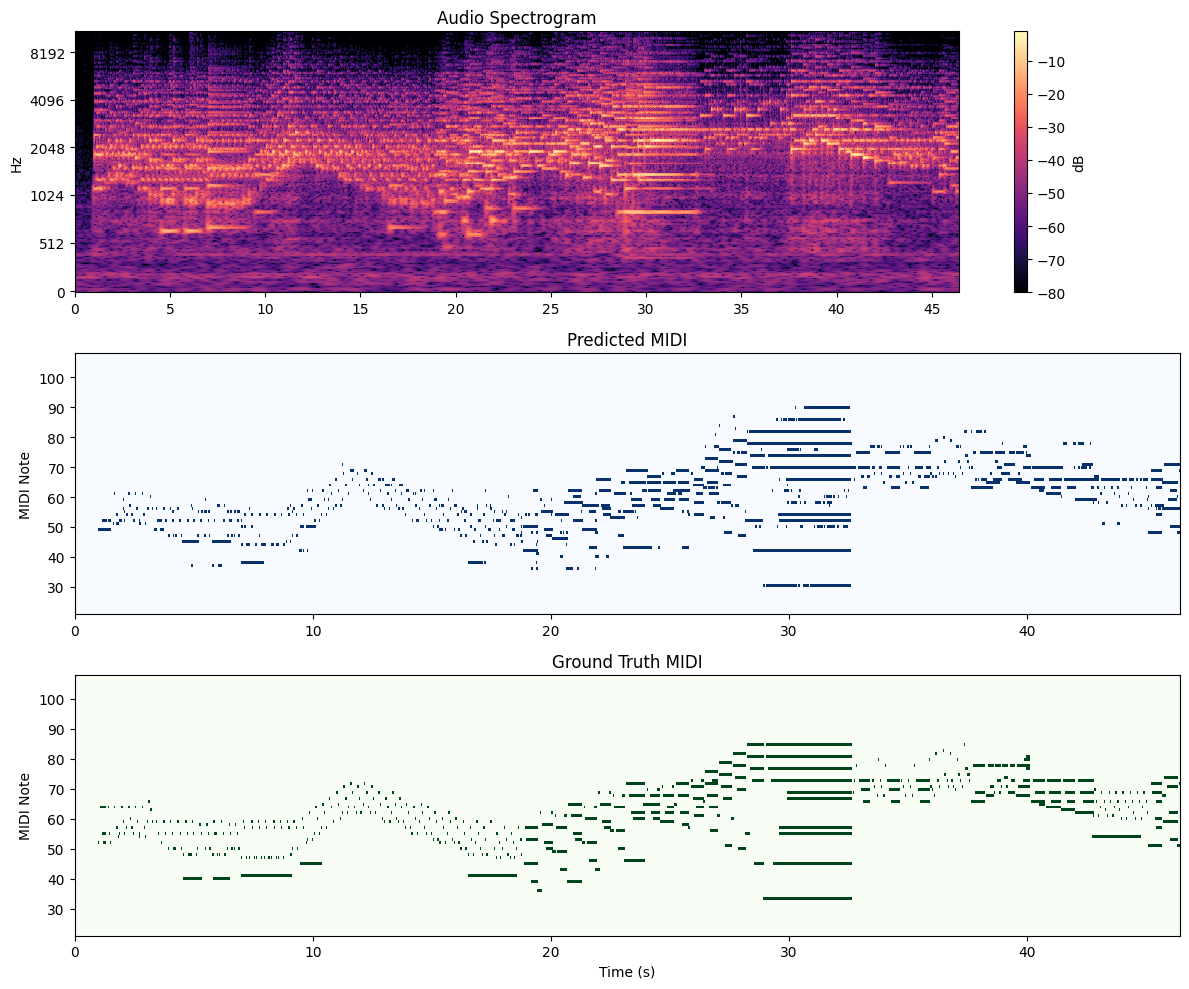

In [19]:
import librosa
from scripts.inference import get_piano_roll, predict, plot_comparison

# Test track with corresponding MIDI
AUDIO_PATH = PROJECT_ROOT / "test_long.wav"
MIDI_PATH = PROJECT_ROOT / "test_long.midi"




audio, _ = librosa.load(AUDIO_PATH, sr=SR, mono=True)

pred_probs, spec = predict(model, audio, n_bins=N_FREQ_BINS, sr=SR, hop=HOP_LENGTH, device=DEVICE)

gt_roll = get_piano_roll(MIDI_PATH, SR, HOP_LENGTH)

plot_comparison(spec, pred_probs, gt_roll, SR, HOP_LENGTH, threshold=THRESHOLD)

In [20]:
from scripts.inference import measure_efficiency
stats = measure_efficiency(model, device='cpu', duration_sec=60, sr=SR, hop=HOP_LENGTH, n_bins=N_FREQ_BINS)

--- Efficiency Report (CPU) ---
Model: CRNNCompactFO
Input duration: 60 sec
Total Params: 1,672,016
Trainable Params: 1,672,016
MACs (FLOPs/2): 53.592G
Avg Inference Time: 1.5553 sec
Real-Time Factor (RTF): 0.0259
Speedup vs Real-time: 38.6x
